In [1]:
%matplotlib inline
import requests
import pandas
import matplotlib.dates as mdates

In [2]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0])
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [3]:
def parse_finam_data(path):
    data = pandas.read_csv(path, dtype={'<DATE>': str, '<TIME>': str})
    data.columns = [c.replace('<','').replace('>','') for c in data.columns]
    data['DATETIME'] = pandas.to_datetime(data.DATE + data.TIME, format='%Y%m%d%H%M%S')
    data.drop('TICKER', axis=1, inplace=True)
    return data

In [4]:
fut = parse_finam_data('data\SPFB.SBRF-12.18_180901_181216.txt')
spot = parse_finam_data('data\SBER_180901_181216.txt')

In [5]:
fut_late = fut[fut.DATETIME.apply(lambda x: x.hour)>18]

In [6]:
late_ohlc = fut_late.CLOSE.groupby(fut_late.DATETIME.apply(lambda x: x.date())).ohlc()
late_vols = fut_late.VOL.groupby(fut_late.DATETIME.apply(lambda x: x.date())).sum()

In [7]:
late_input = late_ohlc
late_input['vol'] = late_vols
late_moves_and_vol = late_ohlc.iloc[:,1:-1].div(late_ohlc.open, axis=0) -1
late_moves_and_vol['vol'] = late_vols

In [8]:
spot_intro = spot[spot.DATETIME.apply(lambda x: x.hour)<12]
spot_intro_ohlc = spot_intro.CLOSE.groupby(spot_intro.DATETIME.apply(lambda x: x.date())).ohlc()
intro_max_moves=pandas.DataFrame({'worst_move': spot_intro_ohlc.low/spot_intro_ohlc.open-1,
                                  'best_move': spot_intro_ohlc.high/spot_intro_ohlc.open-1})
intro_close_moves = spot_intro_ohlc.close/spot_intro_ohlc.open - 1

In [9]:
data = late_moves_and_vol
data['next_day_spot_intro_move'] = intro_close_moves.shift(-1)
data.dropna(inplace=True)

In [10]:
filtered = data[(data.vol > data.vol.quantile(0.5))]

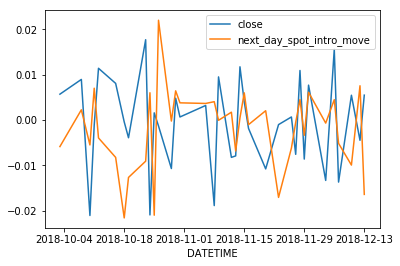

In [11]:
filtered[['close','next_day_spot_intro_move']].plot()

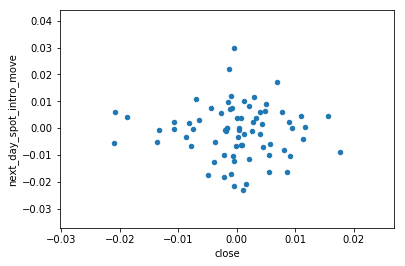

In [12]:
data.plot.scatter(x='close',y='next_day_spot_intro_move')

In [13]:
merged = pandas.merge(fut.set_index('DATETIME')[['CLOSE']],
                      spot.set_index('DATETIME')[['CLOSE']],
                      on='DATETIME',
                      how='left',
                      suffixes=('_fut', '_spot'))
merged.fillna(method='ffill', inplace=True)
merged['CLOSE_spot'] = merged['CLOSE_spot']*100

In [14]:
for_plot = merged
for_plot['DIFF'] = (for_plot['CLOSE_fut']-for_plot['CLOSE_spot'])

In [15]:
'''
for_plot = merged.iloc[-800:-300]
ax = (for_plot['CLOSE_y']-for_plot['CLOSE_x']).plot(figsize=(20,10), style='o', markersize=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
'''

"\nfor_plot = merged.iloc[-800:-300]\nax = (for_plot['CLOSE_y']-for_plot['CLOSE_x']).plot(figsize=(20,10), style='o', markersize=2)\nax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))\n"

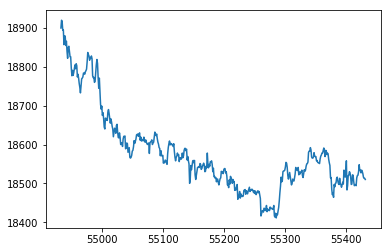

In [16]:
fut.CLOSE.iloc[-800:-300].plot()

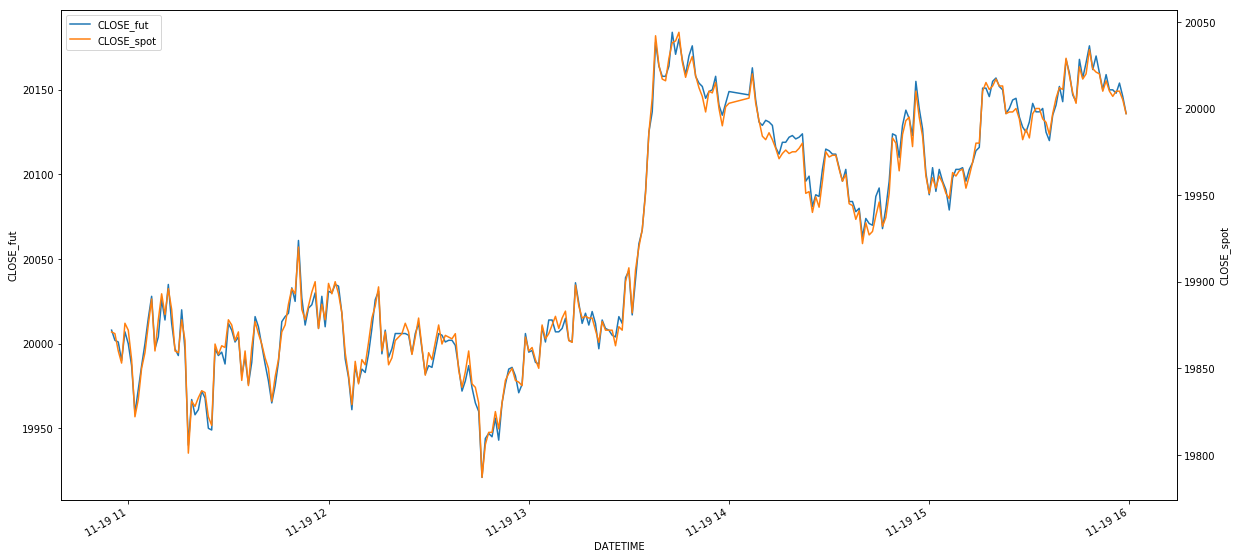

In [17]:
plot_multi(for_plot.iloc[-16100:-15800], cols=['CLOSE_fut', 'CLOSE_spot'], figsize=(20,10))

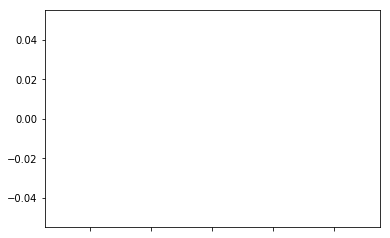

In [18]:
(for_plot.iloc[-16100:-15800].DIFF/100 - for_plot.iloc[-16100:-15800].mean()/100).plot()

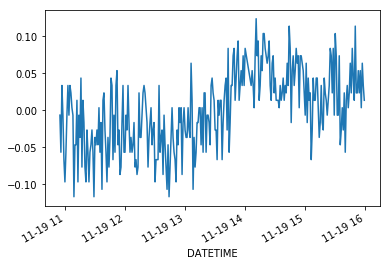

In [19]:
(for_plot.iloc[-16100:-15800].DIFF/100 - for_plot.iloc[-16100:-15800].DIFF.mean()/100).plot()